# Encoder-only Architecture for Text Classification

Recall that the chief reason for using machine learning models over traditional, lexicon-based sentiment analysis is that like lexicon-based approaches to text classifcation rely on fixed dictionaries, which results in them missing context, irony, or slang. ML models, especially deep learning models, learn complex patterns from data, making them particularly useful for more modern text, such as social media posts and online discussions. 


Generally, for text classification tasks, it is faster to use an encoder-only model like BERT, as we don't need to worry about generating some kind of output sequence- all we are doing is classifying text with some pre-defined labels. In other words, our focus is on *understanding* text rather than *generating* text, so it is both faster, and less computationally expensive, to use encoder-only models like BERT. 

## 0. Data Importing and Cleaning

As mentioned, ML-based text classification works the best for nuanced text with lots of slang. Hence, we'll test it on a dataset of recently-scraped *r/UBC* posts. 


```bash
!pip install transformers # you likely don't have this installed.
!pip install pytorch # you likely don't have this installed.
!pip install datasets # you likely don't have this installed.
!pip install numpy
!pip install pandas
!pip install seaborn
```

In [1]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch
import re
import pandas as pd
from transformers import pipeline
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset

In [2]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased") # to break our reddit posts down into tokens
model = AutoModelForMaskedLM.from_pretrained("google-bert/bert-base-uncased") # our model

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at google-bert/bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense

The reddit dataset is dated around late February 2025, however, you are free to scrape newer posts locally by `cd`-ing into the currect directory and running `python project/docs/4_Advanced/advanced_encoder_classifier/r_ubc_scraper.py` in your terminal. This will generate a fresh new set of post/comment datasets for our analysis.

In [3]:
# Load the dataset
reddit_comments = pd.read_csv('Data/r_ubc_comments.csv')
reddit_posts = pd.read_csv("Data/r_ubc_posts.csv")

In [4]:
# Merging datasets
reddit_data = reddit_posts.merge(reddit_comments.groupby("post_id")["body"].apply(lambda x: " ".join(x)), left_on="id", right_on ='post_id', how="left")
reddit_data["full_text"] = reddit_data['title'] + ['    '] + reddit_data["selftext"].fillna('') + ['    '] + reddit_data["body"].fillna('')

In [5]:
# Convert from UTC to detailed month, date, day of week and hour
reddit_data['created_utc'] = pd.to_datetime(
    reddit_data['created_utc'], 
    unit='s',  # Timestamp is in seconds
    utc=True    # Enforce UTC timezone
)

reddit_data['month'] = reddit_data['created_utc'].dt.month_name() 
reddit_data['date'] = reddit_data['created_utc'].dt.day            
reddit_data['day_of_week'] = reddit_data['created_utc'].dt.day_name()  
reddit_data['hour'] = reddit_data['created_utc'].dt.hour    

def clean_text(text):
    if isinstance(text, str):  
        text = text.lower()                         
        text = re.sub(r"http\S+", "", text)         
        text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  
        return text.strip()                         
    else:
        return ""                      

reddit_data["clean_text"] = reddit_data["full_text"].apply(clean_text)       

## 1. Labelling using a pre-trained roBERTa model

Here we used a pre-trained model from hugging face to generate sentiment labels for each posts. Specifically, we'll be using `cardiffnlp/twitter-roberta-base-sentiment-latest`, a model pre-trained on English twitter texts. It classifies emotions into three categories:  0 -> Negative; 1 -> Neutral; 2 -> Positive.  

If you want to work on datasets containing multiple languages, you can use `google-bert/bert-base-multilingual-uncased`, it is a model pretrained on on the top 102 languages with the largest Wikipedia using a masked language modeling (MLM) objective. You can find more information about it on <https://huggingface.co/google-bert/bert-base-multilingual-uncased>.

In [6]:
emotion_classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest", tokenizer="cardiffnlp/twitter-roberta-base-sentiment-latest")

reddit_data["sentiment"] = reddit_data["clean_text"].apply(lambda x: emotion_classifier(x[:512])[0]["label"] if pd.notna(x) else "neutral")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


Here we are using another pre-trained model to generate topic labels for each posts. Specfically, we are using `cardiffnlp/tweet-topic-base-multilingual`, a model pre-trained on ~198M multilingual tweets and finedtuned for English, Spanish, Japanese, and Greek. You can find information about its labels on <https://huggingface.co/cardiffnlp/tweet-topic-base-multilingual>. 

Unfortunately, there hasn't yet to be a "good" multilingual model for topic classifications for some languages up untill Feburuary 2025, but I believe you can always find something that works for your demand on <https://huggingface.co/models>.

In [7]:
import pandas as pd
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from scipy.special import expit

# Load model and tokenizer
MODEL = "cardiffnlp/tweet-topic-base-multilingual"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Get class mapping
class_mapping = model.config.id2label

# Define function for prediction
def classify_text(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    output = model(**tokens)
    
    # Process scores and apply sigmoid
    scores = output[0][0].detach().numpy()
    scores = expit(scores)
    
    # Convert scores to binary predictions
    predictions = (scores >= 0.5) * 1
    
    # Get predicted labels
    predicted_labels = [class_mapping[i] for i in range(len(predictions)) if predictions[i]]
    
    return ", ".join(predicted_labels)  # Join multiple labels into a single string


reddit_data["topic"] = reddit_data["clean_text"].apply(classify_text)

reddit_data["topics"] = reddit_data["topic"].apply(lambda x: x.split(","))

In [8]:
reddit_data["multi_labels"] = reddit_data.apply(lambda row: row["topics"] + [row["sentiment"]], axis=1)

reddit_data.to_csv('Data/r_reddit_data.csv', index=False)

In [9]:
dataset = load_dataset("csv", data_files="Data/r_reddit_data.csv")['train']

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
# Split training and testing data
split_dataset = dataset.train_test_split(
    test_size=0.2,   
    seed= 114514                
)

train_data = split_dataset["train"]
test_data = split_dataset["test"]

In [11]:

# Check the distribution of labels from the training set
train_labels = pd.Series(train_data["multi_labels"])
print("Training Set:\n",train_labels.value_counts(normalize=True))

# Check the distribution of labels from the testing set
test_labels = pd.Series(test_data["multi_labels"])
print("Testing Set:\n",test_labels.value_counts(normalize=True))

Training Set:
 ['diaries_&_daily_life', ' learning_&_educational', ' youth_&_student_life', 'negative']    0.097468
['diaries_&_daily_life', ' learning_&_educational', ' youth_&_student_life', 'neutral']     0.096203
['learning_&_educational', ' youth_&_student_life', 'neutral']                              0.053165
['diaries_&_daily_life', ' relationships', 'negative']                                      0.040506
['diaries_&_daily_life', 'neutral']                                                         0.034177
                                                                                              ...   
['film_tv_&_video', ' music', 'neutral']                                                    0.001266
['diaries_&_daily_life', ' gaming', 'neutral']                                              0.001266
['film_tv_&_video', 'positive']                                                             0.001266
['diaries_&_daily_life', ' learning_&_educational', ' news_&_social_concern'

We can visualize the share of different labels with a pie chart.

                          train_count  test_count
topics                                           
                                    4           1
arts_&_culture                      7           1
business_&_entrepreneurs           43          15
celebrity_&_pop_culture             6           2
diaries_&_daily_life              522         134
family                              6           0
fashion_&_style                     7           0
film_tv_&_video                    13           0
fitness_&_health                   36           7
food_&_dining                      24           6
gaming                             12           1
learning_&_educational            321          92
music                              16           3
news_&_social_concern             157          37
other_hobbies                      31           3
relationships                      67          10
science_&_technology               48          17
sports                             16           3


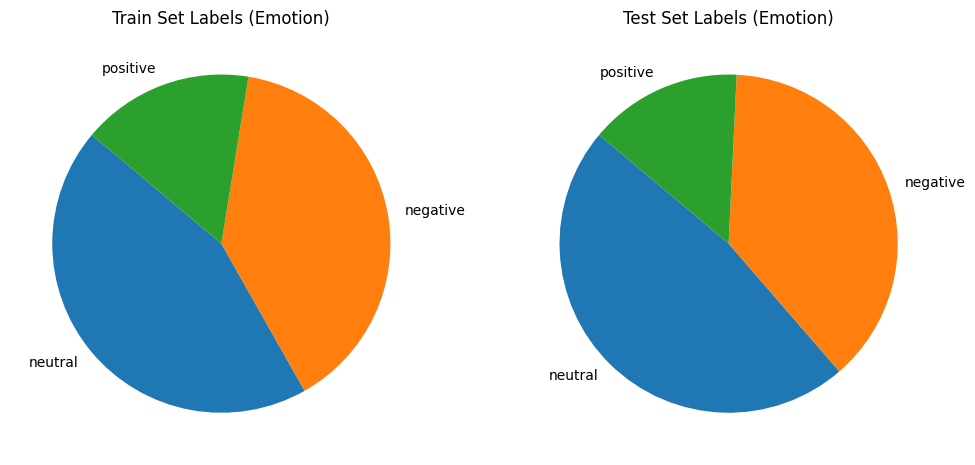

In [22]:
# Show topics summary
def clean_topics(topic_list):
    if isinstance(topic_list, list):
        return [topic.strip() for topic in topic_list]
    return topic_list 

train_df = train_data.to_pandas()
test_df = test_data.to_pandas()

train_df["topics"] = train_df["topics"].apply(lambda x: eval(x) if isinstance(x, str) else x)
test_df["topics"] = test_df["topics"].apply(lambda x: eval(x) if isinstance(x, str) else x)

train_df["topics"] = train_df["topics"].apply(clean_topics)
test_df["topics"] = test_df["topics"].apply(clean_topics)

train_exploded = train_df.explode("topics")
test_exploded = test_df.explode("topics")

train_counts = train_exploded["topics"].value_counts()
test_counts = test_exploded["topics"].value_counts()

distribution_df = pd.DataFrame({
    "train_count": train_counts,
    "test_count": test_counts
}).fillna(0).astype(int)

print(distribution_df)

# Plot the Pie Chart
train_emotion_counts = pd.Series(train_data["sentiment"]).value_counts()
test_emotion_counts = pd.Series(test_data["sentiment"]).value_counts()

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
train_emotion_counts.plot.pie(startangle=140, title="Train Set Labels (Emotion)")
plt.ylabel('')

plt.subplot(1,2,2)
test_emotion_counts.plot.pie(startangle=140, title="Test Set Labels (Emotion)")
plt.ylabel('')

plt.show()

## 2. Training Classifier

### 1. OneVsRestClassifier

This is our first classifying strategy, which consists in fitting one binary classifier per class.

For example, if you want to classify 3 types of fruits, apple, banana and orange with this strategy, you will need to train 3 binary classifiers. The first of these classifiers determines if it is an apple, the second is responsible for determining if it is a banana, and the third is responsible for determining if it is an orange.

The 3 classifiers will then vote for the given new observation, the voting result will be shown as probability. Let's say we have a new observation that we are unsure what type of fruit it is, so we feed this observation to our classifier. The "Apple" classifier claims it's 80% likely an apple, the "Banana" classifier claims it's 10% likely a banana, and the "Orange" classifier claims it's 50% likely an orange. Then we classify based on the highest probability that our new object is an apple.

While it is simple and effective, this strategy has its drawback -- What if there are large amount of labels for us to classify? What if the labels have specific hierarchies? In the first situation, it may take a lot of time to train multiple classifiers for this task; and in the second situation, we could make a lot of mistakes using binary classification. Then we'd better use alternative strategies. 

Anyhow, this is a good way to begin encoder classification.

### 2. MultiOutputClassifier 

This strategy consists of fitting one classifier per target. This is a simple strategy for extending classifiers that do not natively support multi-target classification. 

It is somewhat similar to the "OneVsRest" strategy we just described, but uses a different approach. Let's go back to the fruit classification example, where in the previous setup we trained 3 different classifiers for 3 different types of fruits. Now, let's say that we basically determine which type of fruit it is by looking at the multiple features shared by these fruits (e.g., color, smoothness, and flavor). Then, the "MultiOutput" strategy would train a classifier to specialize in one variable. 

You may have noticed that this overcomes the shortcomings of the “OneVsRest” strategy to a certain extent, especially when there are more “labels” than training variables. However, when we have more variables than labels, this strategy is less efficient than the “OneVsRest” strategy. Therefore, we need to be cautious when choosing our strategy. 


### 3. ClassifierChain

We are finally coming to our last strategy -- It is to train multi-label model that arranges binary classifiers into a chain.  

I'll stick with the fruit categorization example (because it's simple and straightforward), and assume that we've used a "MultiOutput" strategy, which provides us with 3 classifiers that deal with 3 different features of the fruit. How can we make them work more efficiently? We want them to work in concert, rather than individually! A "ClassifierChain" can also discover correlations between these variables handled by the classifiers, thus improving the quality of the classification by sharing common knowledge and "pass on" the evidence chain.

While this strategy sounds smarter than the first two, it has its drawbacks. First, it is more prone to false correlation and over-fitting. Second, it requires more resources to train. Third, when there are fewer covariates, the improvement that this strategy may bring is not significant. Therefore, special care should be taken when deciding to adopt this strategy!

Now that we've finished this short tutorial on 3 different classification strategies, we will show how to train a basic encoder for our purposes using an example. Before we begin, we need to install the necessary package.
```bash
$ pip install setfit
```

In [ ]:

torch.cuda.empty_cache()

training_device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(torch.version.cuda)
print(torch.__version__)

In [ ]:
# Set RAM distribution strategy
import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

print("PYTORCH_CUDA_ALLOC_CONF:", os.getenv("PYTORCH_CUDA_ALLOC_CONF"))

In [ ]:
from setfit import SetFitModel
# model_id = "sentence-transformers/paraphrase-mpnet-base-v2"

model_id = "sentence-transformers/all-MiniLM-L6-v2"

# Here we use a pre-trained model for classification, you can also find other models on https://huggingface.co/ 
model = SetFitModel.from_pretrained(model_id, device="cpu", max_seq_length=256)

model.model_head

In [ ]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, max_length=256)

train_data = train_data.map(tokenize_function, batched=True)
test_data = test_data.map(tokenize_function, batched=True)

train_data.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_data.set_format("torch", columns=["input_ids", "attention_mask", "label"])



In [ ]:
training_args = TrainingArguments(
    output_dir='./results',              
    num_train_epochs=3,                  
    per_device_train_batch_size=16,         
)


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
accuracy_metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

In [ ]:
training_args.batch_eval_metrics = True
# Initialize the Trainer with the provided datasets, model, and tokenizer
setattr(training_args, 'full_determinism', False)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    tokenizer=tokenizer,
)

preds = model.predict(test_data['text'])

In [ ]:
metrics = trainer.evaluate()

metrics

In [ ]:
# Save our model
model.save_pretrained("./my_setfit_model")

After saving our first model, we need to check the quality of the data.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# calculate confusion matrix
y_true = test_data["label"]
y_pred = model.predict(test_data["text"])

# sort labels
classes = sorted(set(y_true)) 

cm = confusion_matrix(y_true, y_pred, labels=classes)

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, linecolor="gray", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()



In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

By looking at this confusion matrix and the classification report, we now realize a key disadvantage of our current model lies in correctly classifying anger.

Another way of checking is to look at the baseline model accuracy 

In [ ]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="stratified")
dummy.fit(train_data["text"], train_data["label"])
baseline_acc = dummy.score(test_data["text"], test_data["label"])
print(f'Baseline Model Accuracy: {baseline_acc:.4f}')

In our case, we see the baseline model accuracy is 0.3889, therefore, our training model made about 0.27 accuracy improvement from the base model.

## Reference